## The problem:
Segment the customer into groups in order to get insight about the buying behavior of the customers.

In [1]:
!conda install -y orange3

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - orange3


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    anyqt-0.0.11               |     pyh9f0ad1d_0          41 KB  conda-forge
    baycomp-1.0.2              |             py_1          18 KB  conda-forge
    ca-certificates-2020.12.5  |       ha878542_0         137 KB  conda-forge
    cachecontrol-0.12.6        |             py_0          18 KB  conda-forge
    certifi-2020.12.5          |   py37h89c1867_0         143 KB  conda-forge
    commonmark-0.9.1           |             py_0          46 KB  conda-forge
    dictdiffer-0.8.0           |             py_0          16 KB  conda-forge
    h11-0.11.0                 |     pyh9f0ad1d_0          44 KB  conda-forge
    h2-4.0.0                   |   py37hc8dfbb8_2          76 KB  conda-forge
    hpack-4.0.0               

In [40]:
import os
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.cm as cm
import math
import seaborn as sns

from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox


%matplotlib inline

In [2]:
cs_df = pd.read_excel('../input/online-retail/Online Retail.xlsx')
cs_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
cs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
print('Columns with null values are:')
for col in cs_df.columns:
    if cs_df[col].isnull().sum() > 0:
        print(col)        

Columns with null values are:
Description
CustomerID


In [5]:
cs_df[cs_df['CustomerID'].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom


In [6]:
cs_df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [7]:
cs_df.corr()

,Quantity,UnitPrice,CustomerID
Quantity,1.000000,-0.001235,-0.00360
UnitPrice,-0.001235,1.000000,-0.00456
CustomerID,-0.003600,-0.004560,1.00000


In [8]:
def rst(df, pred = None):
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: x.unique())
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/obs)*100
    skewness = df.skew()
    kurtosis = df.kurt()
    
    if pred == None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis = 1, sort=True)
    else:
        df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis = 1, sort=True)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis', corr_col ]
        
    str.columns = cols
    return str

In [9]:
details = rst(cs_df)
details

,types,counts,distincts,nulls,missing ration,uniques,skewness,kurtosis
Country,object,541909,38,0,0.000000,"[United Kingdom, France, Australia, Netherland...",NaN,NaN
CustomerID,float64,406829,4373,135080,24.926694,"[17850.0, 13047.0, 12583.0, 13748.0, 15100.0, ...",0.029835,-1.179982
Description,object,540455,4224,1454,0.268311,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...",NaN,NaN
InvoiceDate,datetime64[ns],541909,23260,0,0.000000,"[2010-12-01T08:26:00.000000000, 2010-12-01T08:...",NaN,NaN
InvoiceNo,object,541909,25900,0,0.000000,"[536365, 536366, 536367, 536368, 536369, 53637...",NaN,NaN
Quantity,int64,541909,722,0,0.000000,"[6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 80...",-0.264076,119769.160031
StockCode,object,541909,4070,0,0.000000,"[85123A, 71053, 84406B, 84029G, 84029E, 22752,...",NaN,NaN
UnitPrice,float64,541909,1630,0,0.000000,"[2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2.1...",186.506972,59005.719097


In [10]:
cs_df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [11]:
cs_df[(cs_df['Quantity'] < 0)&~(cs_df['CustomerID'].isnull())]['InvoiceNo'].apply(lambda x: x[0]).unique()

array(['C'], dtype=object)

In [12]:
print('Check if we have neigative quantity and price at same register:', 'No' if cs_df[(cs_df['Quantity']<0)&(cs_df['UnitPrice'] < 0)].shape[0] == 0 else 'Yes', '\n')
print('Check how many register we have where the quality neigative and the price is 0 and vice-versa: ', cs_df[(cs_df['Quantity'] <= 0)&(cs_df['UnitPrice']<=0)].shape[0],'\n')
print('What is the customer id of the register above: ', cs_df[(cs_df['Quantity']<=0)&(cs_df['UnitPrice']<=0)]['CustomerID'].unique(), '\n')
print('% Neigative Quantity: {:%}'.format(cs_df[cs_df['Quantity']<=0].shape[0]/cs_df.shape[0]), '\n')
print('All register with neigative Quantity has Invoice start with: ', cs_df[(cs_df['Quantity'] < 0)&~(cs_df['CustomerID'].isnull())]['InvoiceNo'].apply(lambda x: x[0]).unique())
print('\nSee an example of negative quantity and others related records:')
display(cs_df[~(cs_df.CustomerID.isnull()) & (cs_df.Quantity <0)])

Check if we have neigative quantity and price at same register: No 

Check how many register we have where the quality neigative and the price is 0 and vice-versa:  1336 

What is the customer id of the register above:  [nan] 

% Neigative Quantity: 1.960477% 

All register with neigative Quantity has Invoice start with:  ['C']

See an example of negative quantity and others related records:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [13]:
print('Check register with UnitPrice negative: ')
display(cs_df[cs_df['UnitPrice']<0])
print('Sale records with CustomerID and zero in UnitPrice: ', cs_df[~(cs_df['CustomerID'].isnull())&(cs_df['UnitPrice']==0)].shape[0])
display(cs_df[~(cs_df['CustomerID'].isnull())&(cs_df['UnitPrice']==0)])

Check register with UnitPrice negative: 


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


Sale records with CustomerID and zero in UnitPrice:  40


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,2011-01-13 15:10:00,0.0,15107.0,United Kingdom
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-02-10 13:08:00,0.0,17560.0,United Kingdom
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2011-03-23 10:25:00,0.0,13239.0,United Kingdom
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,2011-03-30 12:45:00,0.0,13113.0,United Kingdom
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,2011-04-04 14:42:00,0.0,14410.0,United Kingdom


In [14]:
#remove registration without CustomerID
cs_df_copy = cs_df[~cs_df['CustomerID'].isnull()]
cs_df_copy.info()

# remove neigative or return transaction
cs_df_copy = cs_df_copy[cs_df_copy['UnitPrice']>0]
cs_df_copy = cs_df_copy[cs_df_copy['Quantity'] >= 0]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [15]:
cs_df_copy.info()
print(cs_df_copy.shape[0]/cs_df.shape[0])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB
0.7342265952401602


In [16]:
cat_des_df = cs_df_copy.groupby(['StockCode', 'Description']).count().reset_index()
cat_des_df

,StockCode,Description,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,10002,INFLATABLE POLITICAL GLOBE,49,49,49,49,49,49
1,10080,GROOVY CACTUS INFLATABLE,21,21,21,21,21,21
2,10120,DOGGY RUBBER,30,30,30,30,30,30
3,10125,MINI FUNKY DESIGN TAPES,64,64,64,64,64,64
4,10133,COLOURING PENCILS BROWN TUBE,124,124,124,124,124,124
...,...,...,...,...,...,...,...,...
3892,C2,CARRIAGE,133,133,133,133,133,133
3893,DOT,DOTCOM POSTAGE,16,16,16,16,16,16
3894,M,Manual,284,284,284,284,284,284
3895,PADS,PADS TO MATCH ALL CUSHIONS,3,3,3,3,3,3


In [17]:
cs_df_copy[cs_df_copy['StockCode'] == cat_des_df.StockCode.value_counts()[cat_des_df.StockCode.value_counts()>1].reset_index()['index'][4]]['Description'].unique()

array(['BUTTERFLY CUSHION COVER', 'LA JARDIN BOTANIQUE CUSHION COVER',
       'LE JARDIN BOTANIQUE CUSHION COVER'], dtype=object)

In [18]:
unique_desc = cs_df_copy[["StockCode", "Description"]].groupby(['StockCode']).apply(pd.DataFrame.mode).reset_index(drop=True)

In [19]:
unique_desc

,StockCode,Description
0,10002,INFLATABLE POLITICAL GLOBE
1,10080,GROOVY CACTUS INFLATABLE
2,10120,DOGGY RUBBER
3,10125,MINI FUNKY DESIGN TAPES
4,10133,COLOURING PENCILS BROWN TUBE
...,...,...
3661,C2,CARRIAGE
3662,DOT,DOTCOM POSTAGE
3663,M,Manual
3664,PADS,PADS TO MATCH ALL CUSHIONS


In [20]:
details = rst(cs_df_copy)
details

,types,counts,distincts,nulls,missing ration,uniques,skewness,kurtosis
Country,object,397884,37,0,0.0,"[United Kingdom, France, Australia, Netherland...",NaN,NaN
CustomerID,float64,397884,4338,0,0.0,"[17850.0, 13047.0, 12583.0, 13748.0, 15100.0, ...",0.025729,-1.180822
Description,object,397884,3877,0,0.0,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...",NaN,NaN
InvoiceDate,datetime64[ns],397884,17282,0,0.0,"[2010-12-01T08:26:00.000000000, 2010-12-01T08:...",NaN,NaN
InvoiceNo,object,397884,18532,0,0.0,"[536365, 536366, 536367, 536368, 536369, 53637...",-0.178524,-1.200748
Quantity,int64,397884,301,0,0.0,"[6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 80...",409.892972,178186.243253
StockCode,object,397884,3665,0,0.0,"[85123A, 71053, 84406B, 84029G, 84029E, 22752,...",NaN,NaN
UnitPrice,float64,397884,440,0,0.0,"[2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2.1...",204.032727,58140.396673


In [21]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [22]:
q = '''
select df.InvoiceNo, df.StockCode, un.Description, df.Quantity, df.InvoiceDate,
       df.UnitPrice, df.CustomerID, df.Country
from cs_df_copy as df INNER JOIN 
     unique_desc as un on df.StockCode = un.StockCode
'''

In [23]:
cs_df_copy = pysqldf(q)
cs_df_copy

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00.000000,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00.000000,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00.000000,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00.000000,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00.000000,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
397879,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00.000000,0.85,12680.0,France
397880,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00.000000,2.10,12680.0,France
397881,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00.000000,4.15,12680.0,France
397882,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00.000000,4.15,12680.0,France


In [24]:
rst(cs_df_copy)

,types,counts,distincts,nulls,missing ration,uniques,skewness,kurtosis
Country,object,397884,37,0,0.0,"[United Kingdom, France, Australia, Netherland...",NaN,NaN
CustomerID,float64,397884,4338,0,0.0,"[17850.0, 13047.0, 12583.0, 13748.0, 15100.0, ...",0.025729,-1.180822
Description,object,397884,3647,0,0.0,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...",NaN,NaN
InvoiceDate,object,397884,17282,0,0.0,"[2010-12-01 08:26:00.000000, 2010-12-01 08:28:...",NaN,NaN
InvoiceNo,int64,397884,18532,0,0.0,"[536365, 536366, 536367, 536368, 536369, 53637...",-0.178524,-1.200748
Quantity,int64,397884,301,0,0.0,"[6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 80...",409.892972,178186.243253
StockCode,object,397884,3665,0,0.0,"[85123A, 71053, 84406B, 84029G, 84029E, 22752,...",NaN,NaN
UnitPrice,float64,397884,440,0,0.0,"[2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2.1...",204.032727,58140.396673


In [25]:
cs_df_copy.InvoiceDate  = pd.to_datetime(cs_df_copy.InvoiceDate)
cs_df_copy['amount'] = cs_df_copy.Quantity*cs_df_copy.UnitPrice
cs_df_copy.CustomerID = cs_df_copy.CustomerID.astype('Int64')
cs_df_copy

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
397879,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20
397880,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60
397881,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60
397882,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60


In [26]:
details = rst(cs_df_copy)
display(details.sort_values(by = 'distincts', ascending = False))

,types,counts,distincts,nulls,missing ration,uniques,skewness,kurtosis
InvoiceNo,int64,397884,18532,0,0.0,"[536365, 536366, 536367, 536368, 536369, 53637...",-0.178524,-1.200748
InvoiceDate,datetime64[ns],397884,17282,0,0.0,"[2010-12-01T08:26:00.000000000, 2010-12-01T08:...",NaN,NaN
CustomerID,Int64,397884,4338,0,0.0,"[17850, 13047, 12583, 13748, 15100, 15291, 146...",0.025729,-1.180822
StockCode,object,397884,3665,0,0.0,"[85123A, 71053, 84406B, 84029G, 84029E, 22752,...",NaN,NaN
Description,object,397884,3647,0,0.0,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...",NaN,NaN
amount,float64,397884,2939,0,0.0,"[15.299999999999999, 20.34, 22.0, 15.3, 25.5, ...",451.443182,232155.117219
UnitPrice,float64,397884,440,0,0.0,"[2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2.1...",204.032727,58140.396673
Quantity,int64,397884,301,0,0.0,"[6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 80...",409.892972,178186.243253
Country,object,397884,37,0,0.0,"[United Kingdom, France, Australia, Netherland...",NaN,NaN


## Visualization

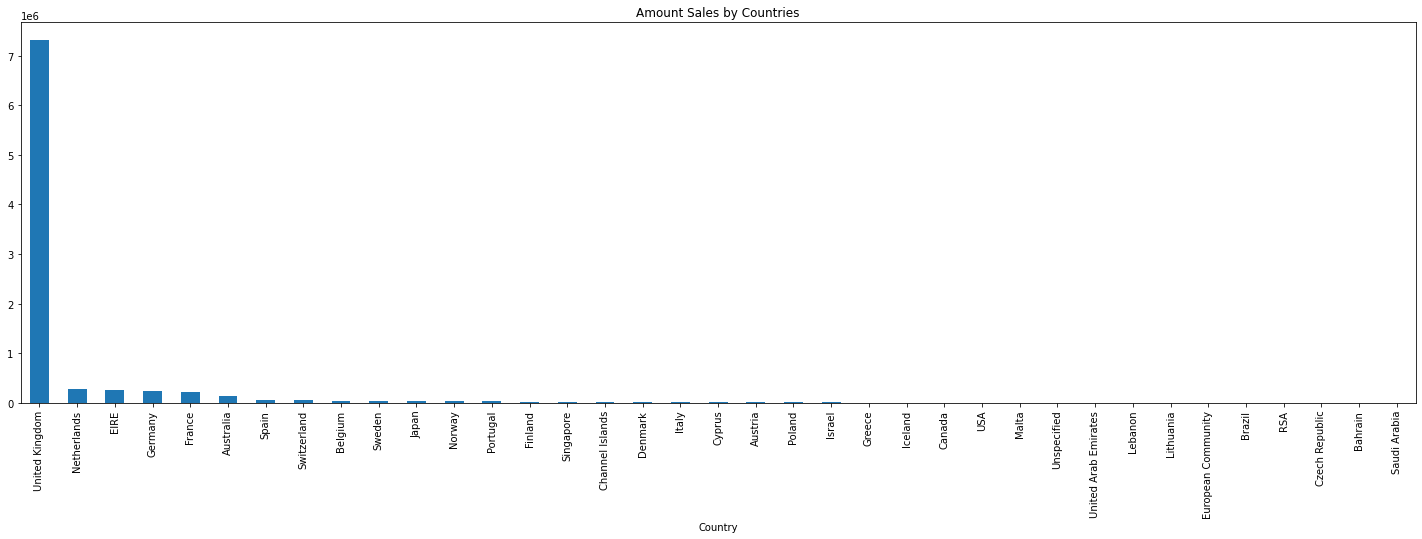

In [27]:
#plot the amount sales by countries
fig = plt.figure(figsize = (25,7))
g = cs_df_copy.groupby(['Country']).amount.sum().sort_values(ascending = False).plot(kind = 'bar', title = 'Amount Sales by Countries')
cs_df_copy['International'] = cs_df_copy.Country.apply(lambda x: 'Yes' if x == 'United Kingdom' else 'No')
plt.show()

In [28]:
cs_df_copy

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,International
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,Yes
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Yes
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,Yes
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Yes
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Yes
...,...,...,...,...,...,...,...,...,...,...
397879,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20,No
397880,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60,No
397881,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60,No
397882,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60,No


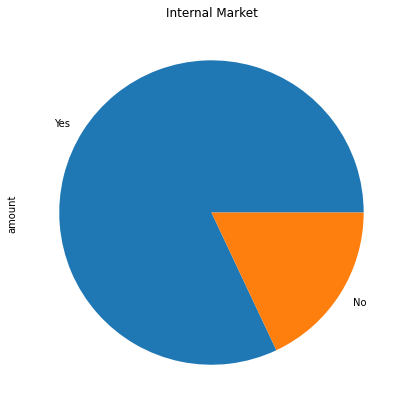

In [29]:
fig = plt.figure(figsize = (25, 7))
h = cs_df_copy.groupby(['International']).amount.sum().sort_values(ascending = False).plot(kind = 'pie', title = 'Internal Market')
plt.show()

In [30]:
#explore customers who buy most
customer_spending = cs_df_copy.groupby(['CustomerID']).amount.sum().sort_values(ascending = False)
customer_spending

CustomerID
14646    280206.02
18102    259657.30
17450    194550.79
16446    168472.50
14911    143825.06
           ...    
16878        13.30
17956        12.75
16454         6.90
14792         6.20
16738         3.75
Name: amount, Length: 4338, dtype: float64

In [31]:
customer_spending_copy = customer_spending.to_frame().reset_index()
total = customer_spending_copy.amount.sum()
customer_spending_copy['cumulative amount'] = customer_spending_copy.amount.cumsum()
customer_spending_copy['percentage amount'] = customer_spending_copy['cumulative amount']/total*100
temp = customer_spending_copy[customer_spending_copy['percentage amount'] <= 35]
L = len(temp)
L

59

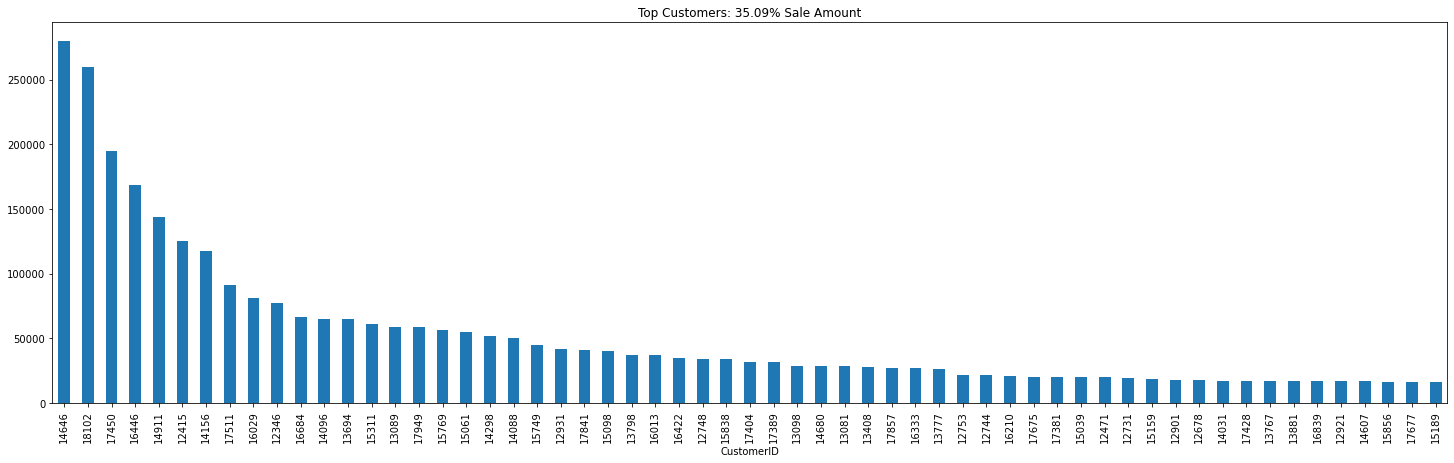

In [32]:
fig = plt.figure(figsize=(25,7))
customer_spending.iloc[:L].plot(kind = 'bar', title = 'Top Customers: {:3.2f}% Sale Amount'.format(customer_spending_copy['percentage amount'].iloc[L]))
plt.show()

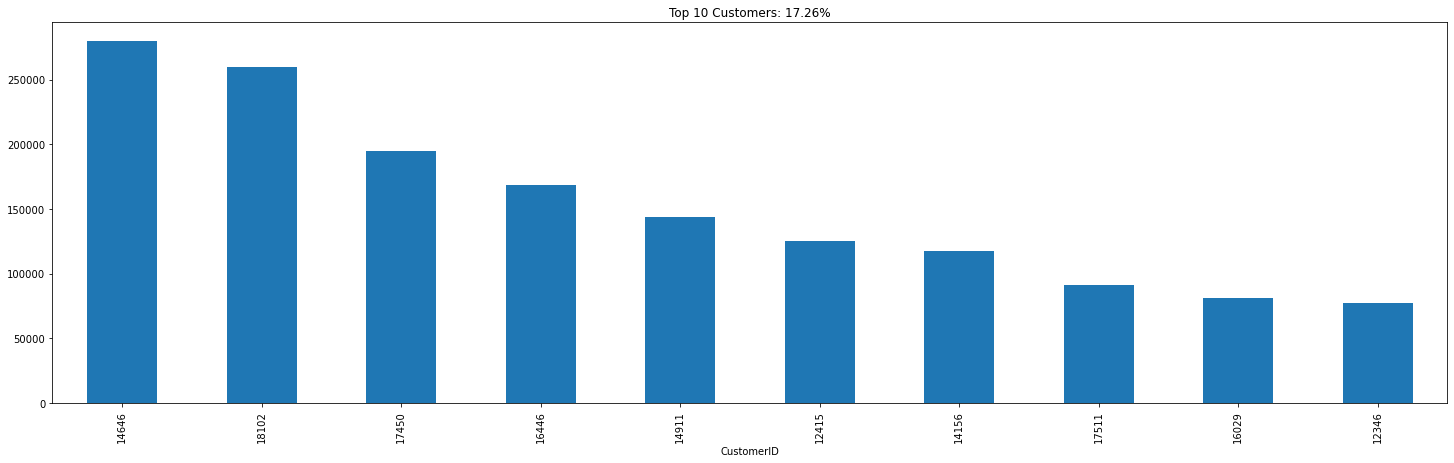

In [33]:
fig = plt.figure(figsize = (25,7))
customer_spending.iloc[:10].plot(kind = 'bar', title = 'Top 10 Customers: {:3.2f}%'.format(customer_spending_copy['percentage amount'].iloc[9]))
plt.show()

In [34]:
#find top sale products


## Customer Segmentation

In [98]:
# create a function to plot distribution of an array and compare the approximate distribution to the normal distribution with the same mean and variance.
# input is a pandas series
def QQ_plot(data, measure):
    #comput the mean, standard deviation, skewness, kurtosis of the data
    mean = data.mean()
    std = data.std()
    skewness = data.skew()
    kurtosis = data.kurt()
    
    fig = plt.figure(figsize = (25,7))
    
    #plot the approximate distribution using kde method
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit = norm)
    fig1.set_title(measure + ' ' + 'distribution (mu = {:2f}, sigma = {:2f})'.format(mean, std), loc = 'center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')
    
    # plot Q-Q 
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot = fig2)
    fig2.set_title(measure + ' ' + 'Probability Plot (skewness = {:2f}, kurtosis = {:2f})'.format(skewness, kurtosis), loc = 'center')
    
    plt.show()

**Recency:** The number of days so far since the last purchase

In [100]:
cs_df_copy

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,International,recency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,Yes,374.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Yes,374.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,Yes,374.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Yes,374.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Yes,374.0
...,...,...,...,...,...,...,...,...,...,...,...
397879,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20,No,1.0
397880,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60,No,1.0
397881,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60,No,1.0
397882,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60,No,1.0


In [101]:
#find the last purchase day in the data set
last_purchase_date = cs_df.InvoiceDate.max() + datetime.timedelta(days = 1)
print('Last purchase date:', last_purchase_date)
cs_df_copy['recency'] = (last_purchase_date - cs_df_copy.InvoiceDate).astype('timedelta64[D]')
customer_history_df = cs_df_copy[['CustomerID', 'recency']].groupby(['CustomerID']).min().reset_index()
customer_history_df

Last purchase date: 2011-12-10 12:50:00


,CustomerID,recency
0,12346,326.0
1,12347,2.0
2,12348,75.0
3,12349,19.0
4,12350,310.0
...,...,...
4333,18280,278.0
4334,18281,181.0
4335,18282,8.0
4336,18283,4.0


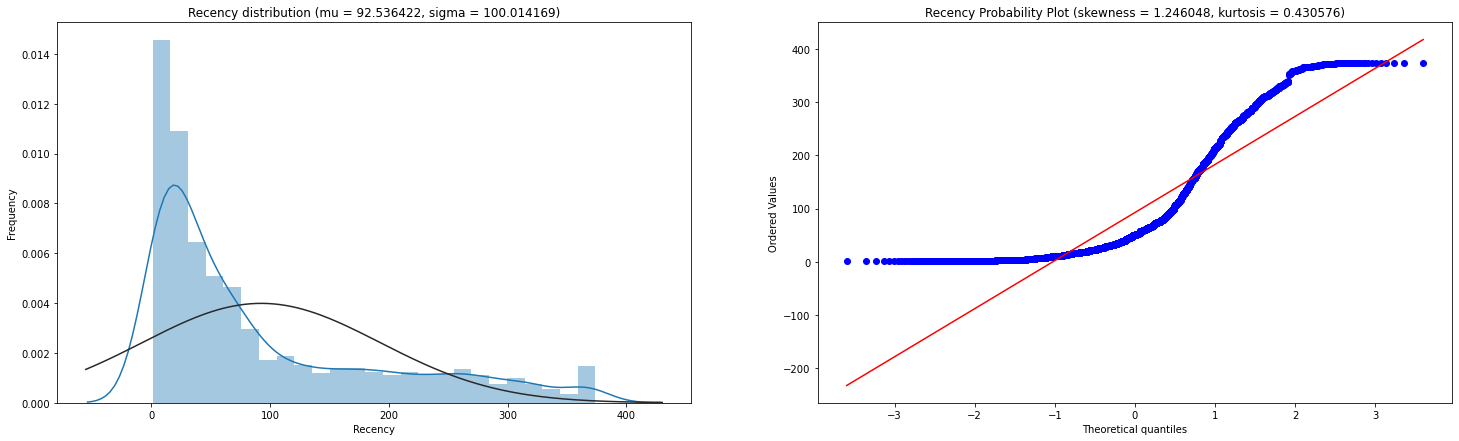

In [102]:
QQ_plot(customer_history_df.recency, 'Recency')    

**Remark:** 

**Frequency:** How frequent the customer's transactions are at the establishment

In [103]:
cs_df_copy

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,International,recency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,Yes,374.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Yes,374.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,Yes,374.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Yes,374.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Yes,374.0
...,...,...,...,...,...,...,...,...,...,...,...
397879,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20,No,1.0
397880,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60,No,1.0
397881,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60,No,1.0
397882,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60,No,1.0


In [77]:
customer_freq =(cs_df_copy[['CustomerID', 'InvoiceNo']].groupby(["CustomerID", 'InvoiceNo']).count().reset_index()).groupby('CustomerID').count().reset_index()
customer_freq.rename(columns = {'InvoiceNo' : 'frequency'}, inplace = True)
customer_freq

,CustomerID,frequency
0,12346,1
1,12347,7
2,12348,4
3,12349,1
4,12350,1
...,...,...
4333,18280,1
4334,18281,1
4335,18282,2
4336,18283,16


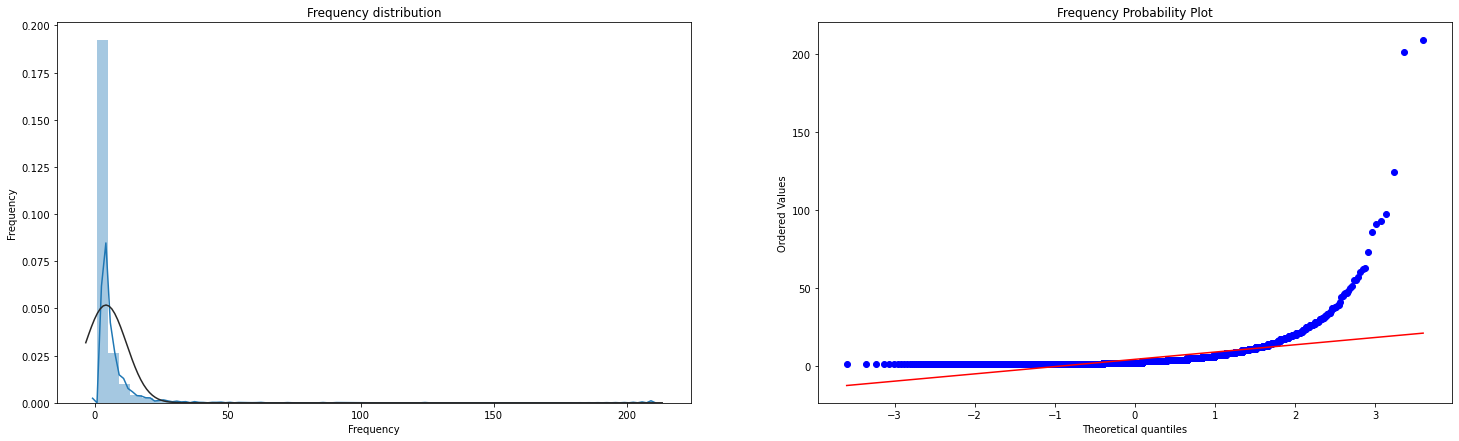

In [80]:
QQ_plot(customer_freq.frequency, 'Frequency')

**Remark:** 

In [78]:
customer_history_df = customer_history_df.merge(customer_freq)
customer_history_df

,CustomerID,recency,frequency
0,12346,326.0,1
1,12347,2.0,7
2,12348,75.0,4
3,12349,19.0,1
4,12350,310.0,1
...,...,...,...
4333,18280,278.0,1
4334,18281,181.0,1
4335,18282,8.0,2
4336,18283,4.0,16


**Monetary value:** The value of all the transactions that the customer mae at the  establishment

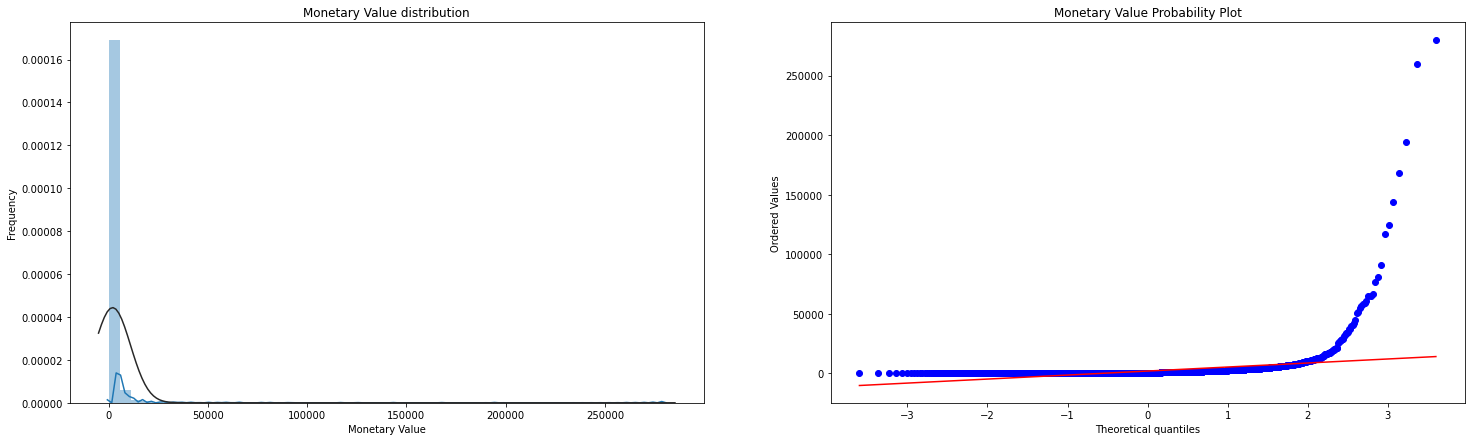

In [84]:
customer_money = cs_df_copy[['CustomerID', 'amount']].groupby(['CustomerID']).sum().reset_index()
QQ_plot(customer_money.amount, 'Monetary Value')

**Remark:**

In [87]:
customer_history_df = customer_history_df.merge(customer_money)
customer_history_df

,CustomerID,recency,frequency,amount
0,12346,326.0,1,77183.60
1,12347,2.0,7,4310.00
2,12348,75.0,4,1797.24
3,12349,19.0,1,1757.55
4,12350,310.0,1,334.40
...,...,...,...,...
4333,18280,278.0,1,180.60
4334,18281,181.0,1,80.82
4335,18282,8.0,2,178.05
4336,18283,4.0,16,2094.88
